In [1]:
!pip install -q transformers torch accelerate bitsandbytes datasets

import json
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
from tqdm import tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 17.0 MB/s eta 0:00:00


In [2]:
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.3"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token_id = tokenizer.eos_token_id

print("Loading model... (This takes a minute)")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto"
)
print("Model loaded successfully!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Loading model... (This takes a minute)


config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Model loaded successfully!


In [3]:
# Load Source Data (TriviaQA) - keeping it small for the test
print("Loading Source Data (TriviaQA)...")
# We use validation set, first 1000 examples for the test run
trivia_qa = load_dataset("trivia_qa", "rc.nocontext", split="validation[:1000]")

wack_data = []

device = "cuda" if torch.cuda.is_available() else "cpu"

print("Generating WACK Dataset...")
for row in tqdm(trivia_qa):
    question = row['question']
    answer = row['answer']['value']

    # does the model get it right 3 times (reduced from 5 for speed in this test)?
    known = True
    prompt = f"Question: {question}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    for _ in range(3):
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=10,
                temperature=0.5,
                do_sample=True,
                pad_token_id=tokenizer.eos_token_id
            )
        gen_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Simple string matching
        if answer.lower() not in gen_text.lower():
            known = False
            break

    if not known:
        continue # skip if model doesn't know (i.e. not factually correct or hallucinate)

    # apply Snowballing to Force Hallucination
    bad_context = """
    Q: What is the capital of France? A: Berlin
    Q: Who wrote Romeo and Juliet? A: Jane Austen
    """
    snowball_prompt = bad_context + f"\nQ: {question}\nA:"

    sb_inputs = tokenizer(snowball_prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        sb_outputs = model.generate(
            **sb_inputs,
            max_new_tokens=10,
            pad_token_id=tokenizer.eos_token_id
        )
    sb_ans = tokenizer.decode(sb_outputs[0], skip_special_tokens=True)

    # 0 = Factually Correct
    # 1 = HK+ (Hallucinated despite knowing)
    # 2 = HK- (Hallucinated without knowledge)
    label = "Factually Correct"

    # We strip the bad context from the answer check to be safe
    generated_only = sb_ans.replace(snowball_prompt, "")

    if answer.lower() not in generated_only.lower():
      if known:
          label = "HK+"
      else:
          label = "HK-"


    wack_data.append({
        "question": question,
        "prompt": snowball_prompt,
        "generated_answer": sb_ans,
        "label": label
    })

# Save the dataset
with open("wack_dataset.json", "w") as f:
    json.dump(wack_data, f)

print(f"Generated {len(wack_data)} WACK examples. Saved to 'wack_dataset.json'.")

Loading Source Data (TriviaQA)...


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

rc.nocontext/train-00000-of-00001.parque(…):   0%|          | 0.00/55.4M [00:00<?, ?B/s]

rc.nocontext/validation-00000-of-00001.p(…):   0%|          | 0.00/7.34M [00:00<?, ?B/s]

rc.nocontext/test-00000-of-00001.parquet:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/138384 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/17944 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/17210 [00:00<?, ? examples/s]

Generating WACK Dataset...


100%|██████████| 1000/1000 [31:53<00:00,  1.91s/it]

Generated 486 WACK examples. Saved to 'wack_dataset.json'.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Loading dataset...
Loaded 486 examples.
Extracting hidden states (this takes time)...


100%|██████████| 486/486 [02:07<00:00,  3.81it/s]


Extraction complete. Data shape: (486, 33, 4096)
--- Balancing Dataset ---
Class 0 (Correct): 363, Class 1 (Hallucination): 123
Downsampling both to 123 samples (Total: 246)...
Training probes on each layer (Balanced Data)...


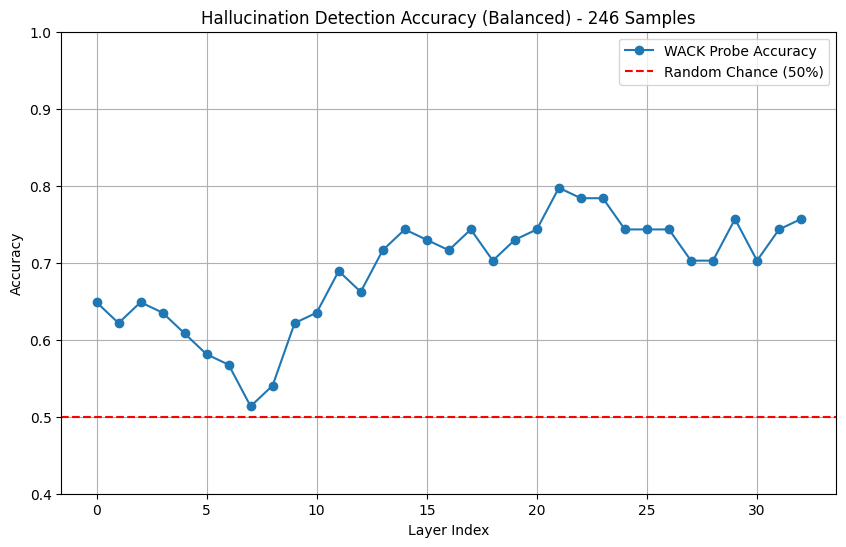

Peak Accuracy: 0.7972972972972973


In [5]:
# load WACK dataset created in the previous step
print("Loading dataset...")
with open("wack_dataset.json", "r") as f:
    dataset = json.load(f)

if len(dataset) == 0:
    raise ValueError("Dataset is empty! Please run the generation step first.")

print(f"Loaded {len(dataset)} examples.")

# define Feature Extractor
def extract_hidden_states(model, tokenizer, text_input):

    inputs = tokenizer(text_input, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    extracted_layers = []
    for layer_tensor in outputs.hidden_states:
        vector = layer_tensor[0, -1, :].float().cpu().numpy()
        extracted_layers.append(vector)

    return np.array(extracted_layers)

# extract Features for the whole dataset
print("Extracting hidden states (this takes time)...")
X_all_layers = []
y_labels = []

for example in tqdm(dataset):
    # Construct the full text used for generation
    full_text = example['prompt'] + example['generated_answer']

    layers_data = extract_hidden_states(model, tokenizer, full_text)
    X_all_layers.append(layers_data)

    # 0 = Factually Correct
    # 1 = HK+ (Hallucinated despite knowing)
    if example['label'] == "Factually Correct":
        y_labels.append(0)
    else:
        y_labels.append(1)

X_all_layers = np.array(X_all_layers)
y_labels = np.array(y_labels)

print(f"Extraction complete. Data shape: {X_all_layers.shape}")

print("--- Balancing Dataset ---")
idx_0 = np.where(y_labels == 0)[0] # Factually Correct
idx_1 = np.where(y_labels == 1)[0] # Hallucination

min_len = min(len(idx_0), len(idx_1))
print(f"Class 0 (Correct): {len(idx_0)}, Class 1 (Hallucination): {len(idx_1)}")
print(f"Downsampling both to {min_len} samples (Total: {min_len*2})...")

idx_0_downsampled = np.random.choice(idx_0, min_len, replace=False)
idx_1_downsampled = np.random.choice(idx_1, min_len, replace=False)

balanced_indices = np.concatenate([idx_0_downsampled, idx_1_downsampled])
np.random.shuffle(balanced_indices)

X_balanced = X_all_layers[balanced_indices]
y_balanced = y_labels[balanced_indices]


# train Layer-wise Classifiers
accuracies = []
num_layers = X_balanced.shape[1]

# Split data (70% train, 30% test)
indices = np.arange(len(y_balanced))
train_idx, test_idx, y_train, y_test = train_test_split(
    indices, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
)

print("Training probes on each layer (Balanced Data)...")
for layer_i in range(num_layers):
    X_layer = X_balanced[:, layer_i, :]

    X_train = X_layer[train_idx]
    X_test = X_layer[test_idx]

    scaler = StandardScaler()
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)

    clf = LinearSVC(max_iter=1_000_000, tol=1e-5, random_state=42, dual="auto")
    clf.fit(X_train_norm, y_train)

    # Evaluate
    preds = clf.predict(X_test_norm)
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)

# 5. Visualize Results
plt.figure(figsize=(10, 6))
plt.plot(range(num_layers), accuracies, marker='o', label='WACK Probe Accuracy')
plt.axhline(y=0.5, color='r', linestyle='--', label='Random Chance (50%)') # Updated label
plt.title(f"Hallucination Detection Accuracy (Balanced) - {len(y_balanced)} Samples")
plt.xlabel("Layer Index")
plt.ylabel("Accuracy")
plt.ylim(0.4, 1.0)
plt.legend()
plt.grid(True)
plt.show()

print("Peak Accuracy:", max(accuracies))